### Data preparation

In [ ]:
# @title
!pip install kaggle
!pip install basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
# @title
from google.colab import files
files.upload()  # Select the kaggle.json file from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"damirz","key":"b34fdd88461fc1081fb785551f2e914e"}'}

In [ ]:
# @title
!mv kaggle.json /content/dataset
!chmod 600 /content/dataset

In [ ]:
# @title
!kaggle datasets download -d yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100% 4.07G/4.07G [02:10<00:00, 41.1MB/s]
100% 4.07G/4.07G [02:10<00:00, 33.5MB/s]


In [ ]:
# @title
!mv yelp-dataset.zip dataset

In [ ]:
# @title
!unzip dataset/yelp-dataset.zip -d dataset


Archive:  dataset/yelp-dataset.zip
  inflating: dataset/Dataset_User_Agreement.pdf  
  inflating: dataset/yelp_academic_dataset_business.json  
  inflating: dataset/yelp_academic_dataset_checkin.json  
  inflating: dataset/yelp_academic_dataset_review.json  
  inflating: dataset/yelp_academic_dataset_tip.json  
  inflating: dataset/yelp_academic_dataset_user.json  


In [1]:
# @title
from google.colab import drive
drive.mount('/content/drive')

!mkdir dataset
!cp -r /content/drive/MyDrive/ml/dataset/* dataset

Mounted at /content/drive


In [ ]:
# package imports
#basics
import numpy as np
import pandas as pd

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.gridspec as gridspec

# graph viz
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go
#map section
import imageio
import folium
import folium.plugins as plugins
#from mpl_toolkits.basemap import Basemap


#graph section
import networkx as nx
import heapq  # for getting top n number of things from list,dict


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
pyo.init_notebook_mode()

%matplotlib inline

---

# YALE DATASET ANALYSIS

first of all, let's upload the data and check the structure

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read and Show JSON Files") \
    .getOrCreate()

business_file = "dataset/yelp_academic_dataset_business.json"
review_file = "dataset/yelp_academic_dataset_review.json"
user_file = "dataset/yelp_academic_dataset_user.json"
checkin_file = "dataset/yelp_academic_dataset_checkin.json"
tip_file = "dataset/yelp_academic_dataset_tip.json"

# Read JSON files into DataFrames
business_df = spark.read.json(business_file)
review_df = spark.read.json(review_file)
user_df = spark.read.json(user_file)
checkin_df = spark.read.json(checkin_file)
tip_df = spark.read.json(tip_file)

# Show data (display the first few rows for each DataFrame)
print("Business Data:")
business_df.show(5, truncate=False)

print("Review Data:")
review_df.show(5, truncate=False)

print("User Data:")
user_df.show(5, truncate=False)

print("Checkin Data:")
checkin_df.show(5, truncate=False)

print("Tip Data:")
tip_df.show(5, truncate=False)


Business Data:
+-------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------+-------+----------+------------+------------------------+-----------+------------+-----+-----+
|address                        |attributes                                                                                                                                                                                                                                                                                     

In [ ]:
import os
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ReadParquetFiles").getOrCreate()

business_df = spark.read.parquet('parquets/business.parquet')
review_df = spark.read.parquet('parquets/reviews.parquet')
user_df = spark.read.parquet('parquets/users.parquet')
checkin_df = spark.read.parquet('parquets/checkins.parquet')
tip_file = spark.read.parquet('parquets/tips.parquet')

check for nulls

In [ ]:
from pyspark.sql.functions import col, when, count
# Select and count null values in each column
null_counts = business_df.select(
    [
        count(when(col(c).isNull(), c)).alias(c)  # Check for null values only
        for c in business_df.columns
    ]
)
# Show null counts for each column
null_counts.show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     13744|          0|       103|   0|23223|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



---

### LET"S FIGURE OUT BUSINESSES THAT GET THE MOST **GOOD** REVIEWS

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc

# Initialize Spark session
spark = SparkSession.builder.appName("Top Businesses by Good Reviews").getOrCreate()

# Load the business and review datasets
business_data = business_df
review_data = review_df

# Remove the attributes and hours columns for simplicity
business_data = business_data.drop("attributes", "hours")

# Filter reviews with 4 or 5 stars (good reviews)
good_reviews = review_data.filter(col("stars") >= 4)

# Join the business and good reviews data on business_id
business_reviews = good_reviews.join(
    business_data,
    on="business_id",
    how="inner"
)

# Count the number of good reviews per business and sort in descending order
top_businesses = business_reviews.groupBy("business_id", "name", "city", "state", "categories") \
    .count() \
    .withColumnRenamed("count", "good_review_count") \
    .orderBy(desc("good_review_count"))

# Show the top businesses with the most good reviews
top_businesses.show(10, truncate=False)

+----------------------+----------------------------------+------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|business_id           |name                              |city        |state|categories                                                                                                                                                                                                                                                                                                                       

### So by sorting we see that top of the most good reviewed business are located in LA, New Orleans
### And most of them are, oh what a surprise, restaraunts

---

# **Users with most useful votes**

In [4]:
user_df.show(10)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+--------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|    name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+--------+------------+------+--------------------+-------------------+
|         3.9

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Top Useful Users").getOrCreate()

# Load user.json
user_data = user_df

# Select relevant fields and order by useful votes
top_useful_users = user_data.select("user_id", "name", "useful") \
                            .orderBy("useful", ascending=False)

top_useful_users.show(10)

+--------------------+--------+------+
|             user_id|    name|useful|
+--------------------+--------+------+
|Hi10sGSZNxQH3NLyW...|     Fox|206296|
|--2vR0DIsmQ6WfcSz...|  Harald|205765|
|JjXuiru1_ONzDkYVr...| Richard|183512|
|lvthTfCQGD0qaEk6j...|   Ariel|182788|
|hWDybu_KvYLSdEFzG...|   Bruce|173089|
|8k3aO-mPeyhbR5HUu...|  Victor|152979|
|Kf5PVQUdDvQYf-MXo...|Marianne|142453|
|AbMjnKOwg736fcIu8...| Michael|124311|
|7W-p-PJlmrzg0mk3p...|  Arshad|117066|
|ax7SnXOTIpatbsmqH...|  Rohlin|112557|
+--------------------+--------+------+
only showing top 10 rows




# **People by their total compliments**


In [ ]:
from pyspark.sql.functions import col, sum as _sum

# Calculate total compliments
user_compliments = user_data.select(
    "user_id", "name",
    (col("compliment_hot") + col("compliment_more") + col("compliment_profile") +
     col("compliment_cute") + col("compliment_list") + col("compliment_note") +
     col("compliment_plain") + col("compliment_cool") + col("compliment_funny") +
     col("compliment_writer") + col("compliment_photos")).alias("total_compliments")
).orderBy("total_compliments", ascending=False)

user_compliments.show(10)

# Join reviews with user compliment data
user_reviews = review_data.join(user_compliments, on="user_id", how="inner") \
                          .select("user_id", "business_id", "total_compliments")

from pyspark.sql.functions import col

# Rename the `review_count` column in `user_reviews` to avoid ambiguity
user_reviews_with_count = user_reviews.withColumnRenamed("count", "user_review_count")

+--------------------+-------+-----------------+
|             user_id|   name|total_compliments|
+--------------------+-------+-----------------+
|JjXuiru1_ONzDkYVr...|Richard|           324328|
|Tqm7Wu7IBJ1td3Ab5...|  Brian|           277314|
|ax7SnXOTIpatbsmqH...| Rohlin|           154351|
|--2vR0DIsmQ6WfcSz...| Harald|           133351|
|h4oOQdnfjpEHbygEJ...|   John|           132032|
|NOUfyJW-BAo_-Cbfo...|  Lolia|           121940|
|Ggx8iUdJ7lsQSqXRu...| Nadine|            99694|
|JRAy4P4op3PCISZaM...|Carissa|            88363|
|giJqvuH8EC62Hi5Wb...|  Dawne|            87736|
|w0Gp4qYFLhB6PbKrP...| Pamela|            87324|
+--------------------+-------+-----------------+
only showing top 10 rows



---
# let's see distribution of stars

<ipython-input-22-0bd59e588643>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=star_distribution_pd['stars'], y=star_distribution_pd['count'], alpha=0.8, palette="viridis")


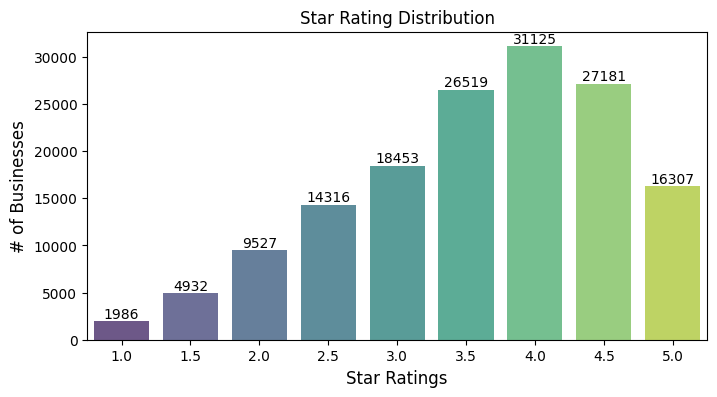

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by the 'stars' column and count the number of businesses
star_distribution = business_df.groupBy("stars").count().orderBy("stars")

# Convert Spark DataFrame to Pandas for visualization
star_distribution_pd = star_distribution.toPandas()

# Plot the distribution
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=star_distribution_pd['stars'], y=star_distribution_pd['count'], alpha=0.8, palette="viridis")
plt.title("Star Rating Distribution")
plt.ylabel('# of Businesses', fontsize=12)
plt.xlabel('Star Ratings', fontsize=12)

# Adding the text labels
rects = ax.patches
labels = star_distribution_pd['count']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

### Makes sense, normal distr

---
# now check top categories

In [ ]:
business_df.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

we see how categories consist of multiple words separated by comma(,)

so we have to split them and group by

In [ ]:
from pyspark.sql.functions import split, explode, col

# Split the categories into an array
business_df = business_df.withColumn("categories_array", split(col("categories"), ","))

# Explode the array into individual rows
categories_df = business_df.select(explode(col("categories_array")).alias("category"))

#Let's count how many are of categories
category_counts = categories_df.groupBy("category").count().orderBy(col("count").desc())

category_counts_pd = category_counts.limit(20).toPandas()

<ipython-input-8-76c28e904963>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts_pd['category'], y=category_counts_pd['count'], alpha=0.8, palette='RdBu')


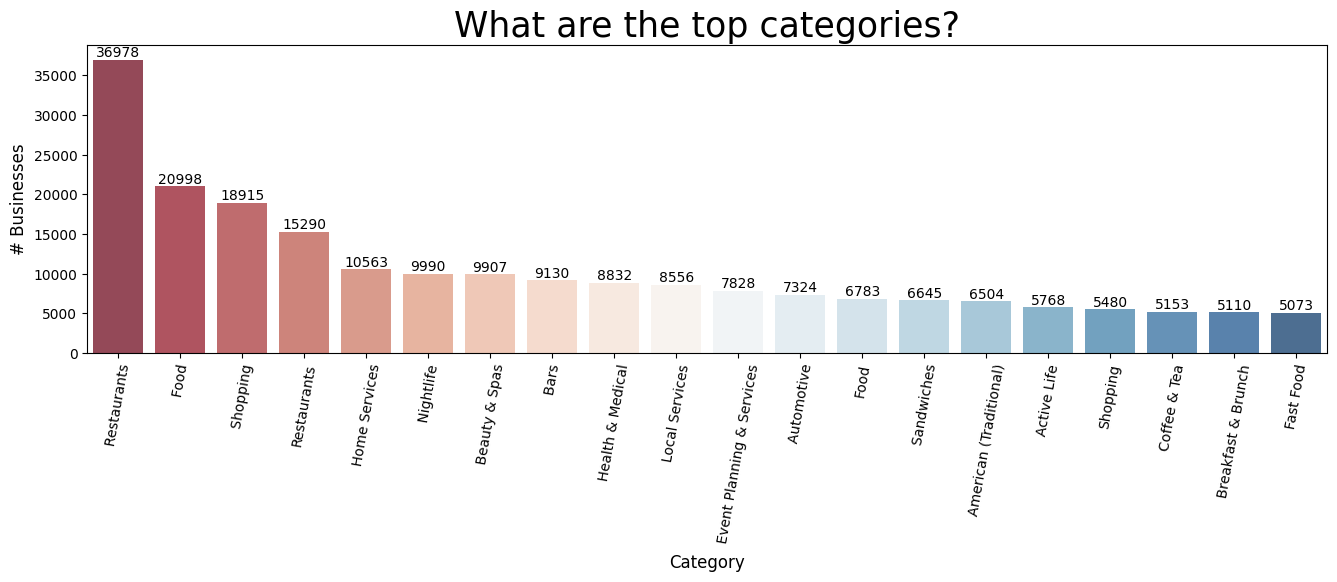

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
ax = sns.barplot(x=category_counts_pd['category'], y=category_counts_pd['count'], alpha=0.8, palette='RdBu')
plt.title("What are the top categories?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Add text labels
rects = ax.patches
labels = category_counts_pd['count']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

---
# If **restaraunt** is the most popular business on Yelp will it be safe to assume that food-related words would be the most popular on reviews

In [27]:
from pyspark.sql.functions import explode, split, col

# Tokenize reviews into words
words_df = review_df.select(
    explode(split(col("text"), r"\s+")).alias("word")
)

# Remove empty strings or null values
filtered_words_df = words_df.filter(col("word") != "")

# Get word counts
word_counts_df = (
    filtered_words_df.groupBy("word")
    .count()
    .orderBy(col("count").desc())
)

# Show the most frequent words
word_counts_df.show(10)

+----+--------+
|word|   count|
+----+--------+
| the|29915947|
| and|25426973|
|   I|18356823|
|   a|18262367|
|  to|17433625|
| was|13224608|
|  of|10288741|
|  is| 8484683|
| for| 8192710|
|  in| 7671822|
+----+--------+
only showing top 10 rows



In [28]:
from pyspark.sql.functions import lower
from pyspark.ml.feature import StopWordsRemover

# Convert words to lowercase
lowered_words_df = filtered_words_df.withColumn("word", lower(col("word")))

# Load stopwords and remove them
stopwords = StopWordsRemover().getStopWords()
cleaned_words_df = lowered_words_df.filter(~col("word").isin(stopwords))

# Get counts of meaningful words
word_counts_cleaned_df = (
    cleaned_words_df.groupBy("word")
    .count()
    .orderBy(col("count").desc())
)

# Show the most frequent meaningful words
word_counts_cleaned_df.show(10)

+-------+-------+
|   word|  count|
+-------+-------+
|   food|2681874|
|  place|2456088|
|  great|2420768|
|   good|2159316|
|   like|2070212|
|    get|2065856|
|    one|1937525|
|   time|1624305|
|service|1618842|
|     go|1557205|
+-------+-------+
only showing top 10 rows



---
# Now let's utilize groupBy method and see how many reviews have people written, and find out how many reviews most active people have written.

In [ ]:
review_df.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|znK6tMeegKf9YnGut...|   0|2021-04-16 22:02:21|    0|MmmrqbdupYBJq9jnl...|  5.0|Great little spot...|     0|TjD2S66AWxlKsPSQB...|
|UxwpCVLgPWCeaRyet...|   0|2021-01-03 21:54:48|    0|1_uWX0bBJNnZjPEcp...|  5.0|James was super k...|     0|Vtfxxq3nxdYHRiH6O...|
|eVI64EQymywsvMLmD...|   0|2020-11-01 19:50:03|    0|WVAEE47MnM3Sv2cvM...|  5.0|By far the best i...|     0|ZDw_qN5Fy6PE0gdbV...|
|SPcPJfPgWzhjUDqVF...|   0|2021-03-24 05:53:49|    0|D5b6iooZZcJ8nG-9P...|  5.0|I thought that th...|     0|UvMDlX2wV4Md9OwGW...|
|T5XzQ6YnVExvd0BOR...|   0|2016-06-13 21:25:10|    0|uDxnT7zWFnxEDxp5e...|  5.0|Aside from

In [ ]:
from pyspark.sql.functions import when

# Step 1: Calculate review counts for each user
user_review_counts_df = review_df.groupBy("user_id").count().withColumnRenamed("count", "review_count")

# Step 2: Cap review counts at 30 for better visuals
user_review_counts_df = user_review_counts_df.withColumn(
    "review_count_capped", when(user_review_counts_df["review_count"] > 30, 30).otherwise(user_review_counts_df["review_count"])
)

# Step 3: Collect the capped review counts for visualization
review_counts = user_review_counts_df.select("review_count_capped").rdd.flatMap(lambda x: x).collect()

In [ ]:
# Step 1: Group by user_id and count the number of reviews for each user
user_review_counts_df = review_df.groupBy("user_id").count()

# Step 2: Sort by review count in descending order
top_users_df = user_review_counts_df.orderBy("count", ascending=False)

# Step 3: Show top 10 users based on number of reviews
top_users_df.show(10, truncate=False)

+----------------------+-----+
|user_id               |count|
+----------------------+-----+
|_BcWyKQL16ndpBdggh2kNA|3048 |
|Xw7ZjaGfr0WNVt6s_5KZfA|1840 |
|0Igx-a1wAstiBDerGxXk2A|1747 |
|-G7Zkl1wIWBBmD0KRy_sCw|1682 |
|ET8n-r7glWYqZhuR6GcdNw|1653 |
|bYENop4BuQepBjM1-BI3fA|1578 |
|1HM81n6n4iPIFU5d2Lokhw|1554 |
|fr1Hz2acAb3OaL3l6DyKNg|1447 |
|wXdbkFZsfDR7utJvbWElyA|1396 |
|Um5bfs5DH6eizgjH3xZsvg|1391 |
+----------------------+-----+
only showing top 10 rows



we see that top user here had written 3 tausend reviews

---
# Now let's ~stalk~ see where the top user have been in   

In [ ]:
# Step 4: Get the user_id of the top user (highest review count)
top_user_id = top_users_df.head(1)[0]['user_id']
print(f"The top user is: {top_user_id}")

The top user is: _BcWyKQL16ndpBdggh2kNA


In [ ]:
from pyspark.sql import functions as F
import folium
from folium.plugins import HeatMapWithTime

# Step 1: Filter reviews for the top user
top_user_reviews_df = review_df.filter(review_df["user_id"] == top_user_id)


# Step 2: Join with business data to get location details
top_user_locs_df = top_user_reviews_df.join(business_df, "business_id").select(
    "latitude", "longitude", "date"
)

# Step 3: Group by date and collect latitudes and longitudes into lists
grouped_locations = (
    top_user_locs_df.groupBy("date")
    .agg(
        F.collect_list("latitude").alias("latitudes"),
        F.collect_list("longitude").alias("longitudes")
    )
    .orderBy("date")
)

# Step 4: Collect the data into Python for visualization
location_data = grouped_locations.collect()

# Step 5: Prepare the heatmap data (list of latitudes and longitudes for each date)
data_for_heatmap = [
    [[lat, lon] for lat, lon in zip(row["latitudes"], row["longitudes"])]
    for row in location_data
]

# Date list for animation
date_list = [row["date"] for row in location_data]

# Step 6: Initialize the map and create a heatmap animation
# Example starting location (Ontario, Canada)
lat, lon = 43.860397, -79.303184
zoom_start = 9

# Create a folium map
m = folium.Map(location=[lat, lon], tiles="Cartodb Positron", zoom_start=zoom_start)

# Add the heatmap with time plugin
hm = HeatMapWithTime(data_for_heatmap, max_opacity=0.3, auto_play=True, display_index=True)
hm.add_to(m)

# Display the map (works in Jupyter or Colab)
m

Looks like he loves Philadelphia

---

# But of course it's interesting to see how many, on average, does user actually write a review

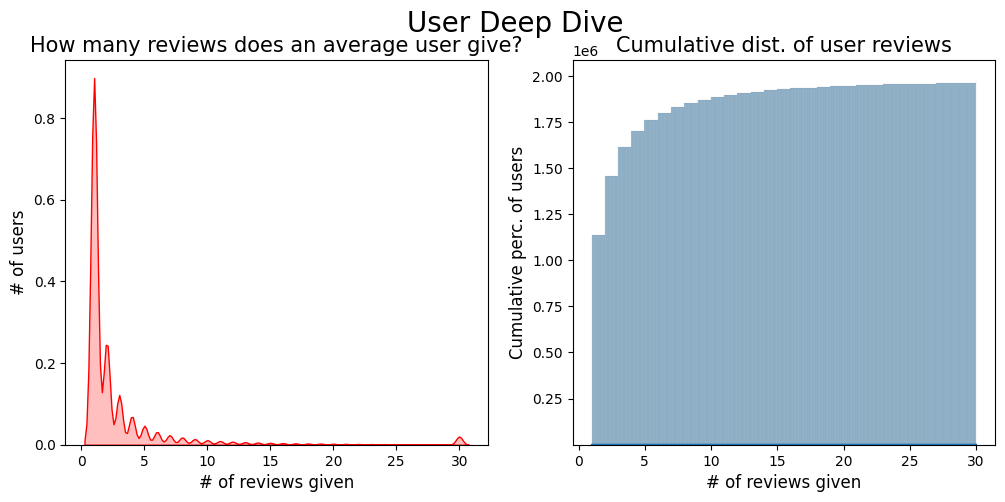

In [ ]:
# Step 4: Generate the KDE and Cumulative Distribution Plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.suptitle("User Deep Dive", fontsize=20)

# Subplot 1: KDE Plot
plt.subplot(1, 2, 1)
sns.kdeplot(review_counts, fill=True, color='r')
plt.title("How many reviews does an average user give?", fontsize=15)
plt.xlabel("# of reviews given", fontsize=12)
plt.ylabel("# of users", fontsize=12)

# Subplot 2: Cumulative Distribution
plt.subplot(1, 2, 2)
sns.histplot(review_counts, cumulative=True, alpha=.4)
sns.ecdfplot(review_counts)
plt.title("Cumulative dist. of user reviews", fontsize=15)
plt.ylabel("Cumulative perc. of users", fontsize=12)
plt.xlabel("# of reviews given", fontsize=12)

plt.show()


Left Plot: KDE Plot
Distribution of Reviews per User:
Most users give very few reviews. The density peaks at a low number of reviews (around 1-2).
The distribution shows a sharp decline as the number of reviews increases. This suggests that heavy reviewers are rare.

The cap at 30 reviews flattens the curve, ensuring extreme outliers do not distort the analysis.
Right Plot: Cumulative Distribution
Cumulative Percentage of Users:
A steep initial rise indicates that a significant majority of users give very few reviews (likely less than 5).

By the time you reach 10 reviews, a large portion of users is already accounted for.
The curve levels off near 30, meaning very few users exceed this limit.

---
# Now let's see top business that get 5-star reviews

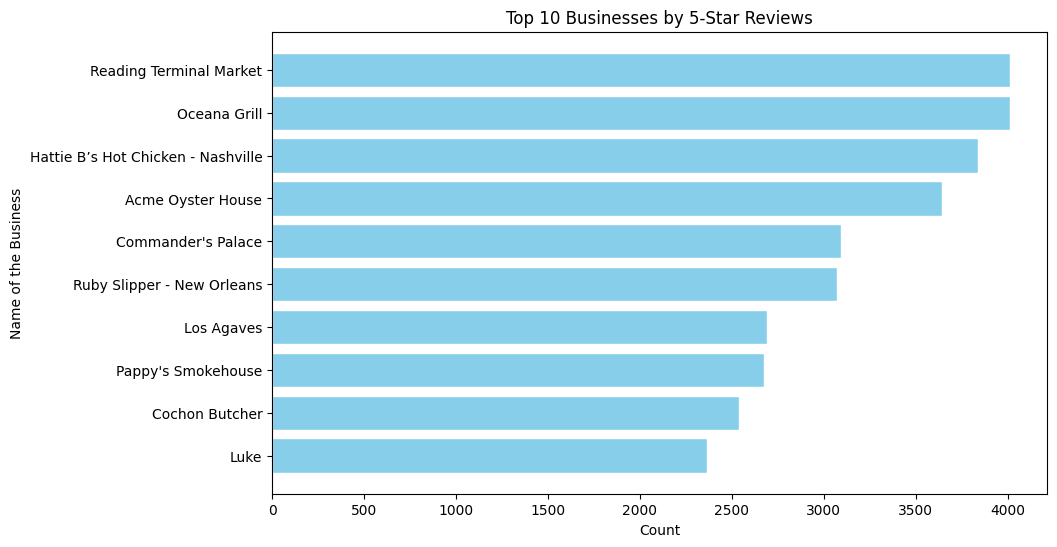

In [ ]:
from pyspark.sql.functions import col, count, desc
import matplotlib.pyplot as plt

# Step 1: Filter for 5-star reviews
five_star_reviews = review_df.filter(col("stars") == 5)

# Step 2: Group by business_id and count the number of 5-star reviews
most5StarsReviews = (
    five_star_reviews.groupBy("business_id")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(10)
)

# Step 3: Join with the business DataFrame to get business names
most5StarsReviews = most5StarsReviews.join(
    business_df, on="business_id", how="inner"
)

# Step 4: Collect the top 10 data for visualization
top_businesses = (
    most5StarsReviews.select("name", "Count")
    .orderBy(desc("Count"))
    .collect()
)

# Prepare data for plotting
names = [row["name"] for row in top_businesses]
counts = [row["Count"] for row in top_businesses]

# Step 5: Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(names, counts, color="skyblue", edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Name of the Business")
plt.title("Top 10 Businesses by 5-Star Reviews")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### Well, indeed **Reading Terminal Market** tops our list, It's a big "Pazar"

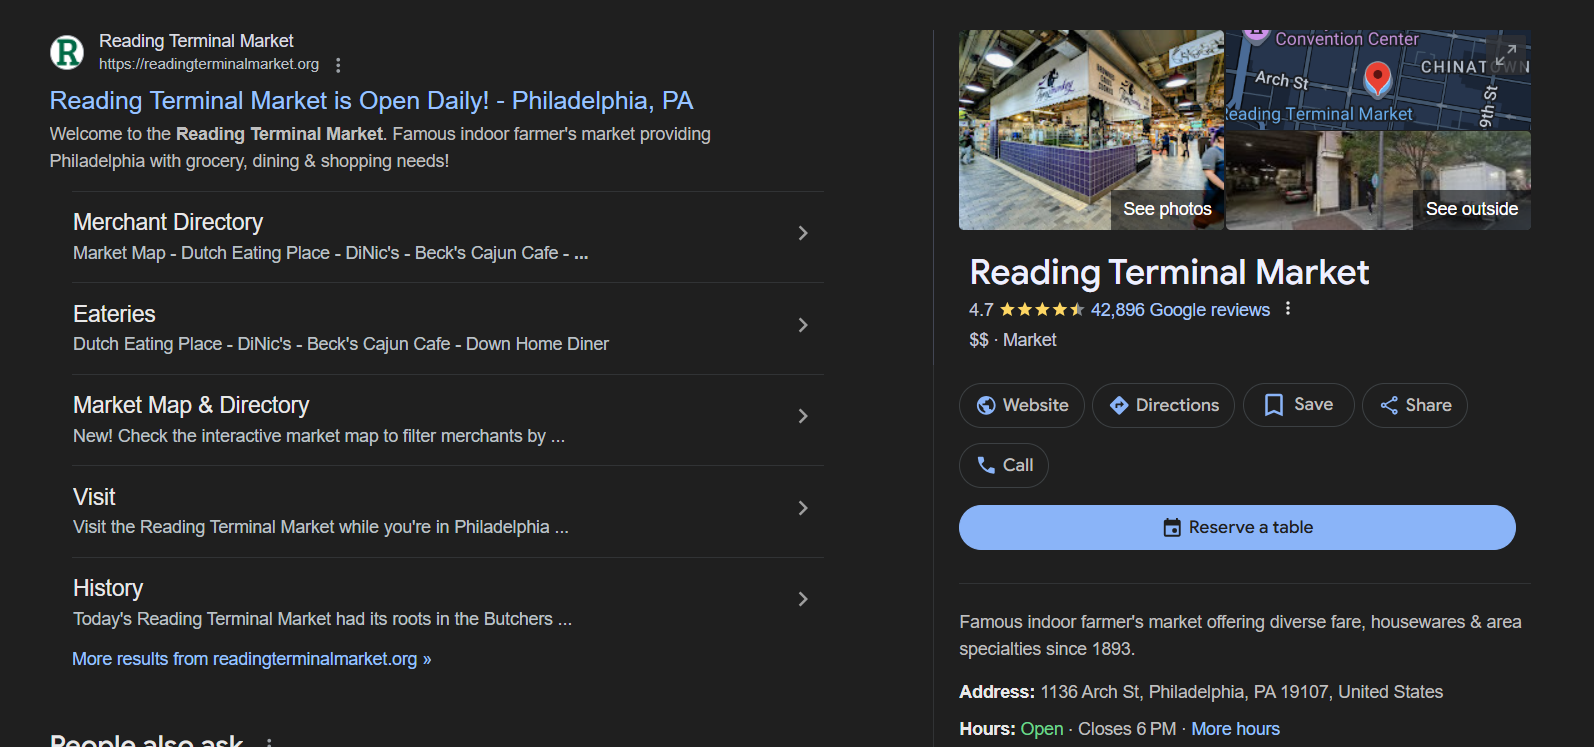

---
### Let's convert to parquet for better storage and import

In [ ]:
output_path = "parquets/"

business_df.write.parquet(output_path + "business.parquet")
review_df.write.parquet(output_path + "reviews.parquet")
tip_df.write.parquet(output_path + "tips.parquet")
user_df.write.parquet(output_path + "users.parquet")
checkin_df.write.parquet(output_path + "checkins.parquet")

In [ ]:
review_df.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [ ]:
from pyspark.sql.functions import length

data = review_df
data = data.withColumn('length', length(data['text']))
data.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|length|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+------+
|znK6tMeegKf9YnGut...|   0|2021-04-16 22:02:21|    0|MmmrqbdupYBJq9jnl...|  5.0|Great little spot...|     0|TjD2S66AWxlKsPSQB...|   326|
|UxwpCVLgPWCeaRyet...|   0|2021-01-03 21:54:48|    0|1_uWX0bBJNnZjPEcp...|  5.0|James was super k...|     0|Vtfxxq3nxdYHRiH6O...|   578|
|eVI64EQymywsvMLmD...|   0|2020-11-01 19:50:03|    0|WVAEE47MnM3Sv2cvM...|  5.0|By far the best i...|     0|ZDw_qN5Fy6PE0gdbV...|   438|
|SPcPJfPgWzhjUDqVF...|   0|2021-03-24 05:53:49|    0|D5b6iooZZcJ8nG-9P...|  5.0|I thought that th...|     0|UvMDlX2wV4Md9OwGW...|   168|
|T5XzQ6YnVExvd0BOR...|   0|2016-06-13 21:

---
### Let's hypothesize, will all reviews with a word "terrible" in it be 1 stars


That's where we can use sparksql

In [8]:
review_df.createOrReplaceTempView("reviews")
#
reviews = spark.sql('SELECT date, review_id, stars, text, user_id, business_id, useful FROM reviews')
#
reviews.createOrReplaceTempView("reviews")
reviews.show(5) # Look at first 5 entries

+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|               date|           review_id|stars|                text|             user_id|         business_id|useful|
+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|2018-07-07 22:09:11|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|     0|
|2012-01-03 15:28:18|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|     1|
|2014-02-05 20:30:30|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|     0|
|2015-01-04 00:01:03|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|     1|
|2017-01-14 20:54:15|Sx8TMOWLNuJBWer-0...|  4.0|Cute interior and...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|     1|
+-------------------+--------------------+-----+

In [12]:
# Find all reviews that include the word "terrible"
reviewsTerrible = \
    spark.sql('\
        SELECT text, stars, useful \
        FROM reviews \
        WHERE text LIKE "%terrible%"')

reviewsTerrible.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Yeah

---

# Let's dive deeper into **date** column

    year  review_count
0   2005           854
1   2006          3853
2   2007         15363
3   2008         48226
4   2009         74387
5   2010        138587
6   2011        230813
7   2012        286570
8   2013        383950
9   2014        522275
10  2015        688415
11  2016        758882
12  2017        820048
13  2018        906362
14  2019        907284
15  2020        554557
16  2021        618189
17  2022         31665


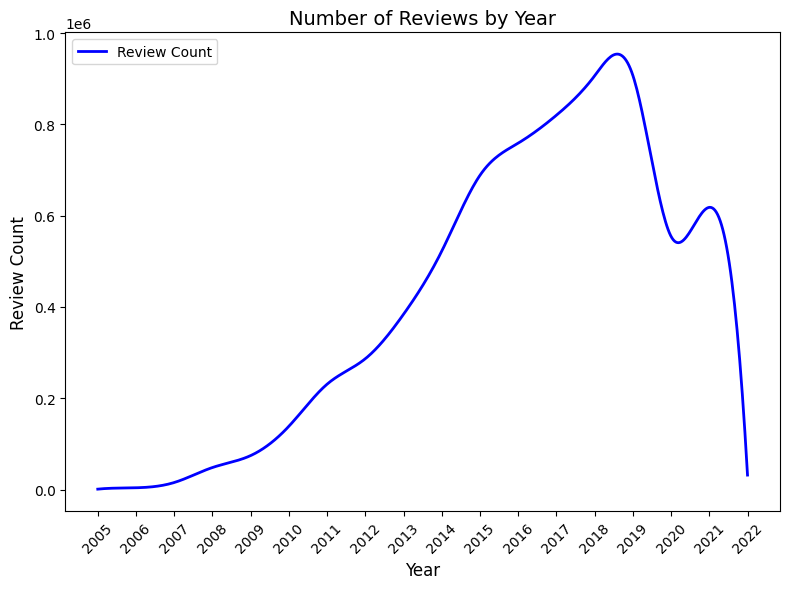

In [20]:
from pyspark.sql.functions import col, year
from pyspark.sql.types import DateType

# Ensure the `date` column is correctly parsed as a DateType
reviews_df = review_df.withColumn("date", col("date").cast(DateType()))

# Extract the year and calculate the number of reviews per year
reviews_by_year = (
    reviews_df
    .withColumn("year", year("date"))
    .groupBy("year")
    .count()
    .withColumnRenamed("count", "review_count")
    .orderBy("year")
)

# Convert Spark DataFrame to Pandas DataFrame
pdf_year = reviews_by_year.toPandas()

# Display Pandas DataFrame
print(pdf_year)

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Prepare data for smooth line plotting
x = pdf_year["year"]
y = pdf_year["review_count"]

# Generate smooth values for x and y
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x, y)(x_smooth)

# Plot the smooth line
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, color='blue', linewidth=2, label='Review Count')

# Add labels, title, and legend
plt.title("Number of Reviews by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.xticks(x, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# *as expected as popularity of internet platforms like yelp grew, number of reviews grows as well, but covid as it seems have affected this, because now people would be, supposedly, more into online shopping rather than visiting irl*

# Let's see if months in general have differences in num of reviews

    month  review_count
0       1        604532
1       2        544125
2       3        598555
3       4        551471
4       5        586575
5       6        601737
6       7        654627
7       8        636384
8       9        565374
9      10        571809
10     11        531518
11     12        543573


<ipython-input-25-a5aecd412357>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


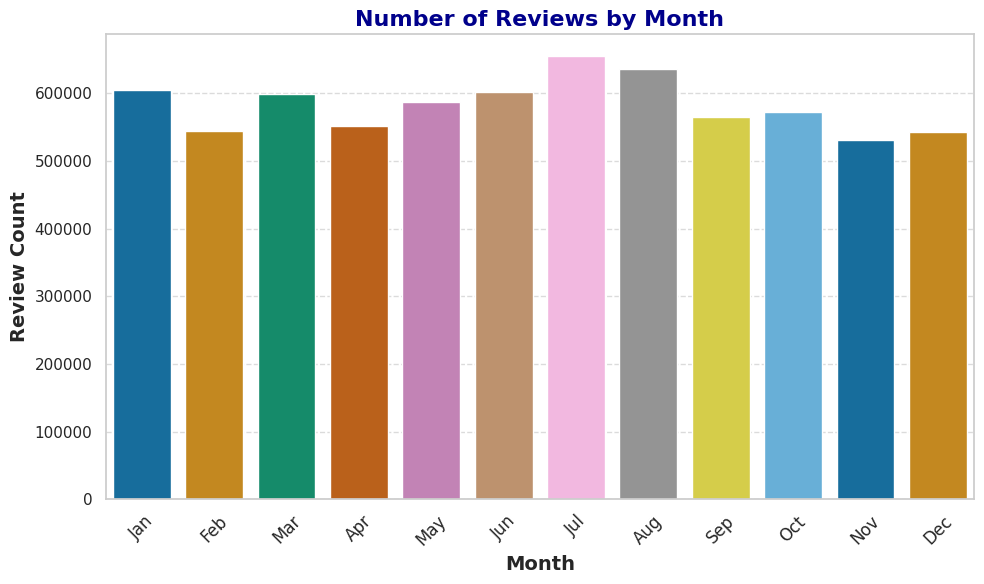

In [25]:
from pyspark.sql.functions import year, month, count

# Apply the built-in functions directly to extract parts of the date and group by month
reviews_by_month = (
    review_df
    .select(
        month("date").alias("month")  # Extract month from date
    )
    .groupBy("month")  # Group by month
    .agg(count("*").alias("review_count"))  # Count reviews per month
    .orderBy("month")  # Order by month
)

# Convert PySpark DataFrame to Pandas DataFrame
pdf_month = reviews_by_month.toPandas()

# Display the result
print(pdf_month)

# Import additional libraries for better styling
import seaborn as sns
import matplotlib.pyplot as plt

# Set a seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))  # Increased size for better visualization
sns.barplot(
    x=pdf_month["month"],
    y=pdf_month["review_count"],
    palette="colorblind"  # Use a gradient blue palette
)

# Add titles and labels with better formatting
plt.title("Number of Reviews by Month", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Month", fontsize=14, fontweight='bold')
plt.ylabel("Review Count", fontsize=14, fontweight='bold')
plt.xticks(
    ticks=range(0, 12),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    fontsize=12, rotation=45
)

# Add gridlines for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()

### And here is the answer, Jul and Aug peaks ofc because they're summer months

---


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, date_format, hour, dayofweek, count

# Initialize Spark Session
spark = SparkSession.builder.appName("CheckInAnalysis").getOrCreate()

# Sample JSON Data
data = checkin_df

# Load data into DataFrame
df = data

# Explode date strings into individual rows
df = df.withColumn("date", explode(split(col("date"), ", ")))

# Extract hour and day of week
df = df.withColumn("hour", hour(col("date")))
df = df.withColumn("day_of_week", dayofweek(col("date")))  # 1=Sunday, 7=Saturday

# Aggregate check-ins by hour and day
hourly_checkins = df.groupBy("hour").agg(count("*").alias("checkins")).orderBy("hour")
daily_checkins = df.groupBy("day_of_week").agg(count("*").alias("checkins")).orderBy("day_of_week")

# Show aggregated results
hourly_checkins.show()
daily_checkins.show()


+----+--------+
|hour|checkins|
+----+--------+
|   0| 1155092|
|   1|  935985|
|   2|  669574|
|   3|  437035|
|   4|  264905|
|   5|  152476|
|   6|   85066|
|   7|   52295|
|   8|   35589|
|   9|   37079|
|  10|   63824|
|  11|  115876|
|  12|  201427|
|  13|  296364|
|  14|  407969|
|  15|  587904|
|  16|  873108|
|  17| 1018438|
|  18|  995358|
|  19|  922177|
+----+--------+
only showing top 20 rows

+-----------+--------+
|day_of_week|checkins|
+-----------+--------+
|          1| 2480701|
|          2| 1491993|
|          3| 1460432|
|          4| 1541769|
|          5| 1612496|
|          6| 1959015|
|          7| 2810469|
+-----------+--------+



<ipython-input-17-030892f8679f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day_of_week", y="checkins", data=checkins_by_day_pd, palette="viridis")


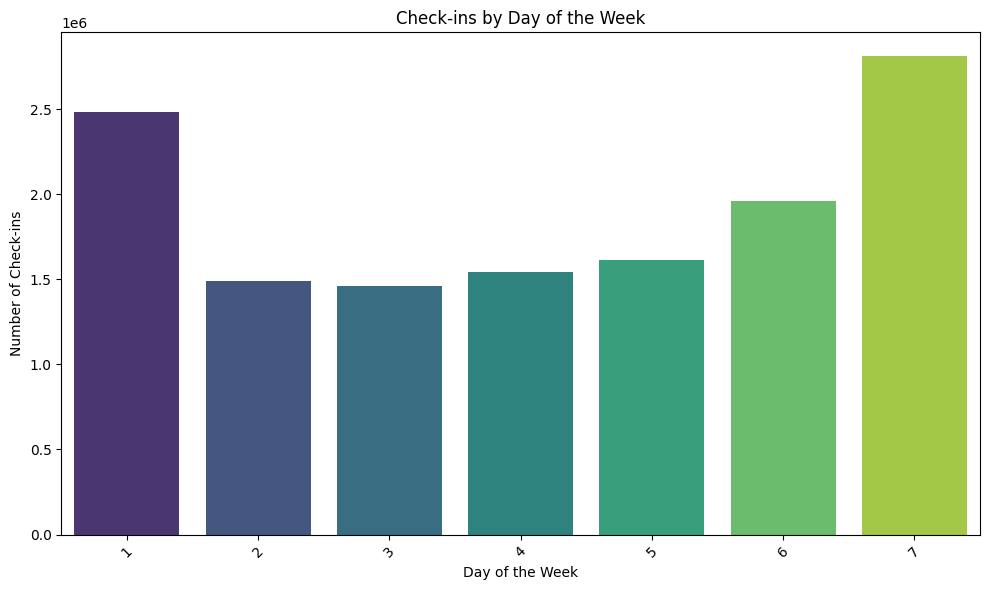

<ipython-input-17-030892f8679f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hour", y="checkins", data=checkins_by_hour_pd, palette="plasma")


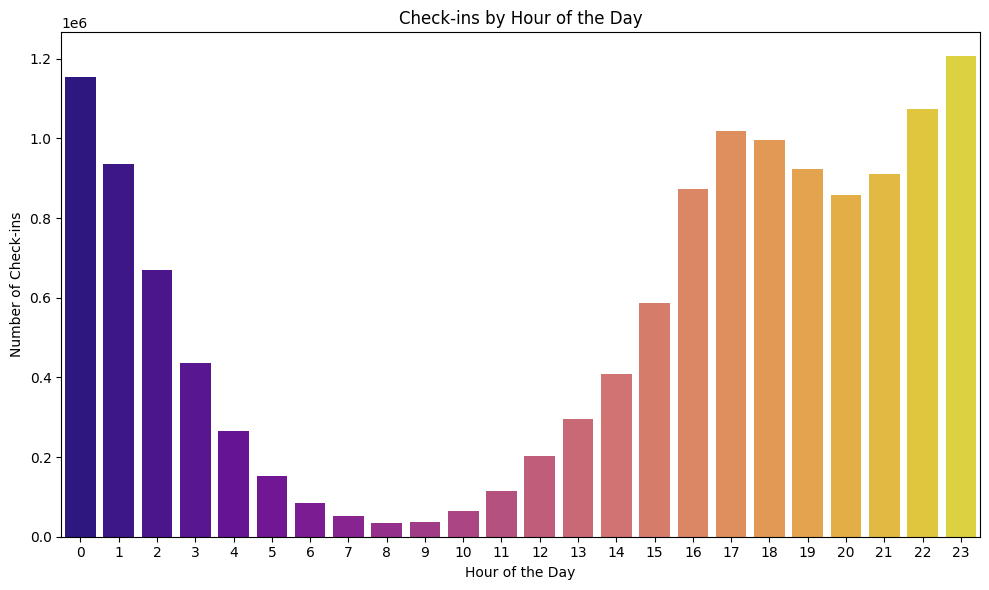

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Collect the results into pandas DataFrames
checkins_by_hour_pd = hourly_checkins.toPandas()
checkins_by_day_pd = daily_checkins.toPandas()

# Create a bar plot for check-ins by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x="day_of_week", y="checkins", data=checkins_by_day_pd, palette="viridis")
plt.title("Check-ins by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Check-ins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a bar plot for check-ins by hour of the day
plt.figure(figsize=(10, 6))
sns.barplot(x="hour", y="checkins", data=checkins_by_hour_pd, palette="plasma")
plt.title("Check-ins by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Check-ins")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()